In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from neuro import config
from os.path import join
sys.path.append(join(config.REPO_DIR, 'experiments'))

import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
from neuro import config
import imodelsx.process_results
import neuro.features.qa_questions as qa_questions
import joblib
from tqdm import tqdm
import neuro.viz
from neuro import analyze_helper, viz
fit_encoding = __import__('02_fit_encoding')
dvu.set_style()

results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/aug4_agentic'
rr, cols_varied, mets = analyze_helper.load_clean_results(results_dir)
# joblib.dump({'r': rr, 'cols_varied': cols_varied, 'mets': mets}, 'results_best_ensemble.pkl')
# data = joblib.load(join(config.RESULTS_DIR_LOCAL, 'results_best_ensemble.pkl'))
# rr, cols_varied, mets = data['r'], data['cols_varied'], data['mets']
metric_sort = 'corrs_test_mean'
rr['num_questions'] = rr['questions_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

/home/chansingh/.venv/lib/python3.12/site-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/home/chansingh/.venv/lib/python3.12/site-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

experiment varied these params: ['subject', 'agent_checkpoint', 'seed']



/home/chansingh/imodelsX/imodelsx/process_results.py:99: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[k] = df[k].fillna(np.nan)


In [2]:
# for name, group in rr.groupby('save_dir_unique'):
#     group = group.sort_values('epoch', ascending=True)
#     display(group[['seed', 'subject', 'agent_checkpoint', 'epoch', 'num_questions', 'corrs_tune_pc_mean_weighted_by_explained_var', 'corrs_test_mean']])

In [6]:
# join 'seed', 'subject', 'agent_checkpoint' into a single col
# rr['legend'] = rr.apply(lambda x: f"{x['seed']}_{x['subject']}_{x['agent_checkpoint']}", axis=1)
rr['legend'] = rr.apply(lambda x: f"{x['agent_checkpoint']}_{x['seed']}", axis=1)

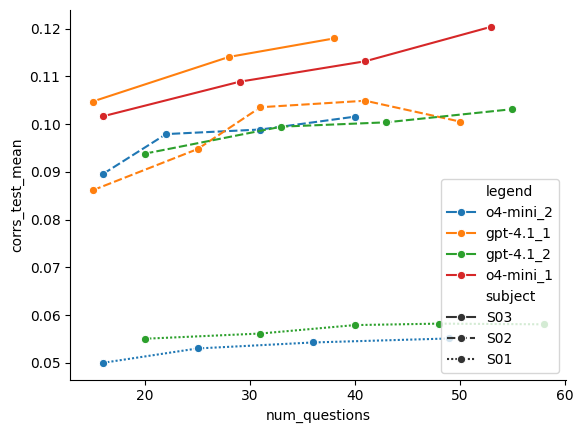

In [11]:
sns.lineplot(
    rr,
    x='num_questions',
    y='corrs_test_mean',
    hue='legend',
    style='subject',
    style_order=['S03', 'S02', 'S01'],
    # hue='subject',
    # estimator='mean',
    marker='o',
)
plt.show()

# visualize questions list

In [ ]:
g = group
questions_list_list = g['questions_list'].tolist()

In [ ]:
questions_list_list

In [ ]:
[len(x) for x in questions_list_list]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import textwrap

def visualize_question_history(history,
                               wrap_width: int = 28,
                               max_questions: int = 100,
                               figsize: tuple = (12, 9),
                               col_labels: list | None = None):
    """
    Draw a static matrix view of how a list of questions evolves over time.
    
    Parameters
    ----------
    history : list[list[str]]
        Sequential snapshots; each inner list is the questions at that time step.
    wrap_width : int, optional
        Number of characters before a sentence is wrapped onto a new line.
    max_questions : int, optional
        Maximum number of unique questions to display (oldest kept first).
    figsize : tuple, optional
        Width, height of the figure in inches.
    col_labels : list[str] | None
        Optional labels for the time steps (default: T0, T1, …).
    """
    if not history:
        raise ValueError("`history` must contain at least one snapshot.")

    # -------- Collect unique questions (oldest first) -----------------------
    seen = {}
    for snap in history:
        for q in snap:
            if q not in seen and len(seen) < max_questions:
                seen[q] = None
    questions = list(seen.keys())
    n_rows, n_cols = len(questions), len(history)

    # -------- Build presence matrix & state map -----------------------------
    present = [[q in snap for snap in history] for q in questions]
    state   = [['absent'] * n_cols for _ in range(n_rows)]

    for r in range(n_rows):
        for c in range(n_cols):
            if present[r][c]:
                if c == 0 or not present[r][c-1]:
                    state[r][c] = 'added'
                else:
                    state[r][c] = 'existing'
            else:
                # mark the previous cell as 'deleted' if it disappears here
                if c > 0 and present[r][c-1]:
                    state[r][c-1] = 'deleted'

    colors = {'absent':  '#FFFFFF',
              'existing':'#E4ECF7',
              'added':   '#B7F5C9',
              'deleted': '#F8C6C4'}

    # -------- Draw ----------------------------------------------------------
    rcParams.update({'font.size': 8})  # small but legible
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.invert_yaxis()
    ax.axis('off')

    # Grid cells + text
    for r, q in enumerate(questions):
        wrapped_q = textwrap.fill(q, wrap_width)
        for c in range(n_cols):
            rect = plt.Rectangle((c, r), 1, 1,
                                 facecolor=colors[state[r][c]],
                                 edgecolor='grey', linewidth=0.5)
            ax.add_patch(rect)
            if present[r][c]:
                ax.text(c+0.5, r+0.5, wrapped_q,
                        ha='center', va='center')

    # Column (time-step) labels
    if col_labels is None:
        col_labels = [f"T{c}" for c in range(n_cols)]
    for c, lbl in enumerate(col_labels):
        ax.text(c+0.5, -0.35, lbl, ha='center', va='center',
                fontsize=9, weight='bold')

    plt.tight_layout()
    return fig, ax


# ---------------------------------------------------------------------------
# Minimal demo
if __name__ == "__main__":
    history = [
        ["Does the input contain a question mark?",
         "Does the input mention time?"],
        ["Does the input contain a question mark?",  # persists
         "Does the input mention time?",             # persists
         "Does the input mention location?"],        # new
        ["Does the input mention location?",         # persists
         "Does the input describe physical sensations?"]  # new
    ]
    
    plt.show()



In [ ]:
visualize_question_history(questions_list_list, wrap_width=32, figsize=(12, 30))